In [1]:
import pandas as pd
import os
import glob

# Specify the path to your main folder containing subfolders with CSV files
main_path = r'C:\ResearchFiles\AllFiles_Cleaned'

# Recursively search for all CSV files in the subfolders
all_files = [f for f in glob.glob(os.path.join(main_path, "**/*.csv"), recursive=True)]

# Combine all files into a single DataFrame
df_list = []
for filename in all_files:
    df = pd.read_csv(filename)
    df['smart_plug'] = os.path.basename(filename).split('_')[1]  # Add a column for the smart plug identifier
    # Optionally, add a column for the building by extracting from the path
    df['building'] = os.path.basename(os.path.dirname(filename))
    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)

In [2]:
# Remove unneccessary columns
combined_df = combined_df.drop(columns = ['analogInput_2', 'analogInput_4', 'analogInput_5', 'binaryInput_3', 'binaryValue_1', 'building'])

# Convert timestamp column to datetime
combined_df['time'] = pd.to_datetime(combined_df['time'])

# Rename the power consumption column more appropriately
combined_df = combined_df.rename(columns = {'analogInput_3': 'power_consumption (mW)'})

# Read in a dataset of abnormal readings to filter for only plugs without any abnormal readings
abnormal_readings = pd.read_csv(r'C:\Users\vaugh\Downloads\helper_spreadsheet(8).csv')
abnormal_readings.drop(columns=['numer_ids'], inplace=True)
abnormal_readings['smart_plug'] = abnormal_readings['smart_plug'].astype(str)
abnormal_readings['smart_plug'] = abnormal_readings['smart_plug'].apply(lambda x: x[:-2])

# Combining the datasets to include the abnormal readings column and setting time as the index
combined_df = combined_df.merge(abnormal_readings, on='smart_plug')
combined_df = combined_df[combined_df['Abnormal Readings'] == 'Clear']
combined_df.drop(columns = ['Abnormal Readings'], inplace=True)

In [3]:
# Import the device type for each plug
device_types = pd.read_csv(r'C:\Users\vaugh\Downloads\helper_spreadsheet(7).csv')

# Rename the device id column to 'smart_plug' to match the other df and Building_Name to building_name
device_types.rename(columns = {'Bacnet_ID': 'smart_plug'}, inplace=True)
device_types.rename(columns = {'Building_Name': 'building_name'}, inplace=True)

In [4]:
device_types

,smart_plug,Load_Type,building_name
0,291824.0,Computer,Atkinson Hall
1,291956.0,Printer,Atkinson Hall
2,292032.0,Printer,Atkinson Hall
3,183436.0,Water Dispenser,Atkinson Hall
4,181084.0,TV,Atkinson Hall
...,...,...,...
776,289580.0,Computer,Wells Fargo Hall
777,182376.0,Printer,Wells Fargo Hall
778,181180.0,TV,Wells Fargo Hall
779,190412.0,Computer,Wells Fargo Hall


In [5]:
# Ensure both smart plug columns have string values to enable merging, and remove the decimals from the device_types df
combined_df['smart_plug'] = combined_df['smart_plug'].astype(str)
device_types['smart_plug'] = device_types['smart_plug'].astype(str)
device_types['smart_plug'] = device_types['smart_plug'].str[:-2]

# Merge the two dataframes and save it as a csv file
merged_df = pd.merge(combined_df, device_types, on='smart_plug')
merged_df.to_csv(r'C:\Users\vaugh\Desktop\smart-plug-research-data\merged_df.csv')

# Filter out all device types leaving only water dispensers
merged_df = merged_df[merged_df['Load_Type'] == 'Water Dispenser']

In [7]:
merged_df

,time,power_consumption (mW),smart_plug,Load_Type,building_name
317896,2023-09-15 17:25:00,6490.0,182728,Water Dispenser,Atkinson Hall
317897,2023-09-15 17:26:00,6490.0,182728,Water Dispenser,Atkinson Hall
317898,2023-09-15 17:27:00,7080.0,182728,Water Dispenser,Atkinson Hall
317899,2023-09-15 17:28:00,6608.0,182728,Water Dispenser,Atkinson Hall
317900,2023-09-15 17:29:00,186320.0,182728,Water Dispenser,Atkinson Hall
...,...,...,...,...,...
98725185,2024-06-10 23:55:00,0.0,564316,Water Dispenser,Telemed
98725186,2024-06-10 23:56:00,0.0,564316,Water Dispenser,Telemed
98725187,2024-06-10 23:57:00,0.0,564316,Water Dispenser,Telemed
98725188,2024-06-10 23:58:00,0.0,564316,Water Dispenser,Telemed


In [8]:
merged_df['day_of_week'] = merged_df['time'].dt.day_name()

# Aggregate power consumption by day of the week and building
weekly_data = merged_df.groupby(['building_name', 'day_of_week']).agg({'power_consumption (mW)': 'mean'}).reset_index()

In [9]:
weekly_data

,building_name,day_of_week,power_consumption (mW)
0,Atkinson Hall,Friday,70518.355956
1,Atkinson Hall,Monday,78861.273223
2,Atkinson Hall,Saturday,56958.212479
3,Atkinson Hall,Sunday,55765.413056
4,Atkinson Hall,Thursday,79025.197676
...,...,...,...
65,Telemed,Saturday,92000.591063
66,Telemed,Sunday,93708.356400
67,Telemed,Thursday,98604.715007
68,Telemed,Tuesday,96508.659519


In [13]:
# Add a column for day of the week
merged_df = merged_df.copy()  # Create a copy to avoid SettingWithCopyWarning
merged_df['day_of_week'] = merged_df['time'].dt.day_name()

# Extract minute of the day
merged_df['minute_of_day'] = merged_df['time'].dt.hour * 60 + merged_df['time'].dt.minute

In [14]:
# Calculate weekly average power consumption for each building
weekly_avg = merged_df.groupby('building_name').agg({'power_consumption (mW)': 'mean'}).reset_index()
weekly_avg.rename(columns={'power_consumption (mW)': 'weekly_avg_consumption'}, inplace=True)

# Merge weekly average with daily data
daily_data = merged_df.groupby(['building_name', 'day_of_week']).agg({'power_consumption (mW)': 'mean'}).reset_index()
daily_data = daily_data.merge(weekly_avg, on='building_name')

# Calculate normalized consumption
daily_data['normalized_consumption'] = daily_data['power_consumption (mW)'] / daily_data['weekly_avg_consumption']

In [11]:
daily_data

,building_name,day_of_week,power_consumption (mW),weekly_avg_consumption,normalized_consumption
0,Atkinson Hall,Friday,46586.898606,47166.451805,0.987713
1,Atkinson Hall,Monday,52024.978525,47166.451805,1.103008
2,Atkinson Hall,Saturday,37590.115623,47166.451805,0.796967
3,Atkinson Hall,Sunday,36791.276176,47166.451805,0.780031
4,Atkinson Hall,Thursday,52321.931762,47166.451805,1.109304
...,...,...,...,...,...
65,Telemed,Saturday,92000.591063,95102.900484,0.967379
66,Telemed,Sunday,93708.356400,95102.900484,0.985336
67,Telemed,Thursday,98604.715007,95102.900484,1.036821
68,Telemed,Tuesday,96508.659519,95102.900484,1.014781


In [15]:
weekly_avg

,building_name,weekly_avg_consumption
0,Atkinson Hall,71445.564107
1,Center Hall,47184.378697
2,EBU3B,74523.399217
3,Geisel Library,54005.604670
4,IRPS Robinson Hall,23203.054165
5,McGill Hall,26107.989665
6,RIMAC,54434.478047
7,Social Sciences Building,57295.239669
8,Student Services Center,66098.988839
9,Telemed,95102.900484


In [13]:
# Input the coordinates of all buildings and map them to the corresponding buildings in the df
coordinates = {
    'Atkinson Hall': (32.882453, -117.234825),
    'Center Hall': (32.877752, -117.237283),
    'EBU3B': (32.881821, -117.233631),
    'Geisel Library': (32.881139, -117.237583),
    'IRPS Robinson Hall': (32.884279, -117.240903),
    'Jacobs Hall': (32.881661, -117.235306),
    'McGill Hall': (32.879026, -117.242079),
    'Otterson Hall': (32.886571, -117.241257),
    'Price Center West': (32.879806, -117.236182),
    'Price Center East Expansion': (32.879743, -117.235688),
    'RIMAC': (32.885259, -117.239578),
    'EBU2': (32.881180, -117.233053),
    'Social Sciences Building': (32.883875, -117.240475),
    'Student Services Center': (32.878573, -117.235807),
    'Telemed': (32.875191, -117.234783),
    'Wells Fargo Hall': (32.886962, -117.241847),
}

In [ ]:
import folium
from folium.plugins import HeatMap

def create_heatmap(day_of_week):
    # Filter data for the selected day of the week
    day_data = daily_data[daily_data['day_of_week'] == day_of_week].copy()  # Use .copy() to avoid warnings
    
    # Get coordinates for buildings
    day_data['coordinates'] = day_data['building_name'].map(coordinates)
    
    # Prepare data for the heatmap
    heat_data = [[row['coordinates'][0], row['coordinates'][1], row['normalized_consumption']] for index, row in day_data.iterrows()]
    
    # Create a base map
    m = folium.Map(location=[32.880000, -117.235000], zoom_start=15)  # Adjust to your campus center coordinates
    
    # Add the heatmap layer
    HeatMap(heat_data, min_opacity=0.2, radius=15, blur=10).add_to(m)
    
    return m

In [ ]:
from dash import Dash, dcc, html
import dash
import dash_bootstrap_components as dbc

app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = html.Div([
    dcc.Dropdown(
        id='day-dropdown',
        options=[{'label': day, 'value': day} for day in weekly_data['day_of_week'].unique()],
        value=weekly_data['day_of_week'].unique()[0]
    ),
    html.Iframe(id='heatmap', srcDoc=create_heatmap(weekly_data['day_of_week'].unique()[0])._repr_html_(), width='100%', height='600px')
])

@app.callback(
    dash.dependencies.Output('heatmap', 'srcDoc'),
    [dash.dependencies.Input('day-dropdown', 'value')]
)
def update_heatmap(day_of_week):
    return create_heatmap(day_of_week)._repr_html_()

if __name__ == '__main__':
    app.run_server(debug=True)

In [ ]:
merged_df

In [ ]:
building_totals_df = merged_df.groupby('building_name').agg({'power_consumption (mW)': 'mean'}).reset_index()
building_totals_df['coordinates'] = building_totals_df['building_name'].map(coordinates)

In [ ]:
building_totals_df

In [ ]:
# Create a map centered around the campus (or a general center point)
m = folium.Map(location=[32.880000, -117.235000], zoom_start=15)

# Prepare data for heatmap (coordinates, weight)
heat_data = [[row['coordinates'][0], row['coordinates'][1], row['power_consumption (mW)']] for index, row in building_totals_df.iterrows()]

# Add heatmap layer to the map
HeatMap(heat_data).add_to(m)

# Add markers with labels for each building
for index, row in building_totals_df.iterrows():
    folium.Marker(
        location=row['coordinates'],
        popup=f"{row['building_name']}<br>Power Consumption: {row['power_consumption (mW)']:.0f} mW",
        tooltip=row['building_name'],  # Tooltip to display on hover
    ).add_to(m)

# Display map
m.save('power_consumption_heatmap_with_labels.html')

In [ ]:
# Create a new df just for computers
merged_df_computers = pd.merge(combined_df, device_types, on='smart_plug')
merged_df_computers = merged_df_computers[merged_df_computers['Load_Type'] == 'Computer']
merged_df_computers['day_of_week'] = merged_df_computers['time'].dt.day_name()

# Add a column for day of the week
merged_df_computers = merged_df_computers.copy()  # Create a copy to avoid SettingWithCopyWarning
merged_df_computers['day_of_week'] = merged_df_computers['time'].dt.day_name()

# Extract minute of the day
merged_df_computers['minute_of_day'] = merged_df_computers['time'].dt.hour * 60 + merged_df_computers['time'].dt.minute

In [ ]:
computer_building_totals_df = merged_df_computers.groupby('building_name').agg({'power_consumption (mW)': 'mean'}).reset_index()
computer_building_totals_df['coordinates'] = computer_building_totals_df['building_name'].map(coordinates)

In [ ]:
import folium
from folium.plugins import HeatMap

# Create a map centered around the campus (or a general center point)
m = folium.Map(location=[32.880000, -117.235000], zoom_start=15)

# Prepare data for heatmap (coordinates, weight)
heat_data = [[row['coordinates'][0], row['coordinates'][1], row['power_consumption (mW)']] for index, row in computer_building_totals_df.iterrows()]

# Add heatmap layer to the map
HeatMap(heat_data).add_to(m)

# Add markers with labels for each building
for index, row in computer_building_totals_df.iterrows():
    folium.Marker(
        location=row['coordinates'],
        popup=f"{row['building_name']}<br>Power Consumption: {row['power_consumption (mW)']:.0f} mW",
        tooltip=row['building_name'],  # Tooltip to display on hover
    ).add_to(m)

# Display map
m.save('computer_power_consumption_heatmap.html')

In [ ]:
# Create a new df just for computers
merged_df_printers = pd.merge(combined_df, device_types, on='smart_plug')
merged_df_printers = merged_df_printers[merged_df_printers['Load_Type'] == 'Printer']
merged_df_printers['day_of_week'] = merged_df_printers['time'].dt.day_name()

# Add a column for day of the week
merged_df_printers['day_of_week'] = merged_df_printers['time'].dt.day_name()

# Extract minute of the day
merged_df_printers['minute_of_day'] = merged_df_printers['time'].dt.hour * 60 + merged_df_printers['time'].dt.minute

In [ ]:
printer_building_totals_df = merged_df_printers.groupby('building_name').agg({'power_consumption (mW)': 'mean'}).reset_index()
printer_building_totals_df['coordinates'] = printer_building_totals_df['building_name'].map(coordinates)

In [ ]:
import folium
from folium.plugins import HeatMap

# Create a map centered around the campus (or a general center point)
m = folium.Map(location=[32.880000, -117.235000], zoom_start=15)

# Prepare data for heatmap (coordinates, weight)
heat_data = [[row['coordinates'][0], row['coordinates'][1], row['power_consumption (mW)']] for index, row in printer_building_totals_df.iterrows()]

# Add heatmap layer to the map
HeatMap(heat_data).add_to(m)

# Add markers with labels for each building
for index, row in printer_building_totals_df.iterrows():
    folium.Marker(
        location=row['coordinates'],
        popup=f"{row['building_name']}<br>Power Consumption: {row['power_consumption (mW)']:.0f} mW",
        tooltip=row['building_name'],  # Tooltip to display on hover
    ).add_to(m)

# Display map
m.save('printer_power_consumption_heatmap.html')

In [ ]:
# Create a new df just for computers
merged_df_tvs = pd.merge(combined_df, device_types, on='smart_plug')
merged_df_tvs = merged_df_tvs[merged_df_tvs['Load_Type'] == 'TV']
merged_df_tvs['day_of_week'] = merged_df_tvs['time'].dt.day_name()

# Add a column for day of the week
merged_df_tvs['day_of_week'] = merged_df_tvs['time'].dt.day_name()

# Extract minute of the day
merged_df_tvs['minute_of_day'] = merged_df_tvs['time'].dt.hour * 60 + merged_df_tvs['time'].dt.minute

In [ ]:
tv_building_totals_df = merged_df_tvs.groupby('building_name').agg({'power_consumption (mW)': 'mean'}).reset_index()
tv_building_totals_df['coordinates'] = tv_building_totals_df['building_name'].map(coordinates)

In [ ]:
import folium
from folium.plugins import HeatMap

# Create a map centered around the campus (or a general center point)
m = folium.Map(location=[32.880000, -117.235000], zoom_start=15)

# Prepare data for heatmap (coordinates, weight)
heat_data = [[row['coordinates'][0], row['coordinates'][1], row['power_consumption (mW)']] for index, row in tv_building_totals_df.iterrows()]

# Add heatmap layer to the map
HeatMap(heat_data).add_to(m)

# Add markers with labels for each building
for index, row in tv_building_totals_df.iterrows():
    folium.Marker(
        location=row['coordinates'],
        popup=f"{row['building_name']}<br>Power Consumption: {row['power_consumption (mW)']:.0f} mW",
        tooltip=row['building_name'],  # Tooltip to display on hover
    ).add_to(m)

# Display map
m.save('tv_power_consumption_heatmap.html')

In [16]:
# Creating new dfs to look at specific buildings' normalized power consumptions
geisel_df = merged_df[merged_df['building_name'] == 'Geisel Library']
mcgill_df = merged_df[merged_df['building_name'] == 'McGill Hall']
IRPS_df = merged_df[merged_df['building_name'] == 'IRPS Robinson Hall']
center_df = merged_df[merged_df['building_name'] == 'Center Hall']

In [17]:
# Create a column for the day of the week
geisel_df = geisel_df.copy()
geisel_df['day_of_week'] = geisel_df['time'].dt.day_name()

# Aggregate power consumption by day of the week
geisel_weekly = geisel_df.groupby(['day_of_week']).agg({'power_consumption (mW)': 'mean'}).reset_index()

# Convert the power consumption values from mW to KW/h and rename the column appropriately
geisel_weekly['power_consumption (mW)'] = geisel_weekly['power_consumption (mW)'] * 60 / 1_000_000
geisel_weekly.rename(columns = {'power_consumption (mW)': 'power_consumption (KW/h)'}, inplace=True)

# Create a column for the normalized consumption, or the consumption compared to the average across the entire campus
geisel_avg_consumption = weekly_avg.loc[weekly_avg['building_name'] == 'Geisel Library', 'weekly_avg_consumption'].values[0] * 60 / 1_000_000
geisel_weekly['normalized_consumption'] = geisel_weekly['power_consumption (KW/h)'] / geisel_avg_consumption

# Set the day of the week to the index
geisel_weekly.set_index('day_of_week', inplace=True)

In [18]:
geisel_weekly

,power_consumption (KW/h),normalized_consumption
day_of_week,,
Friday,3.338614,1.030329
Monday,3.289349,1.015126
Saturday,2.922078,0.901782
Sunday,2.878706,0.888397
Thursday,3.465994,1.069640
Tuesday,3.360891,1.037204
Wednesday,3.457573,1.067041


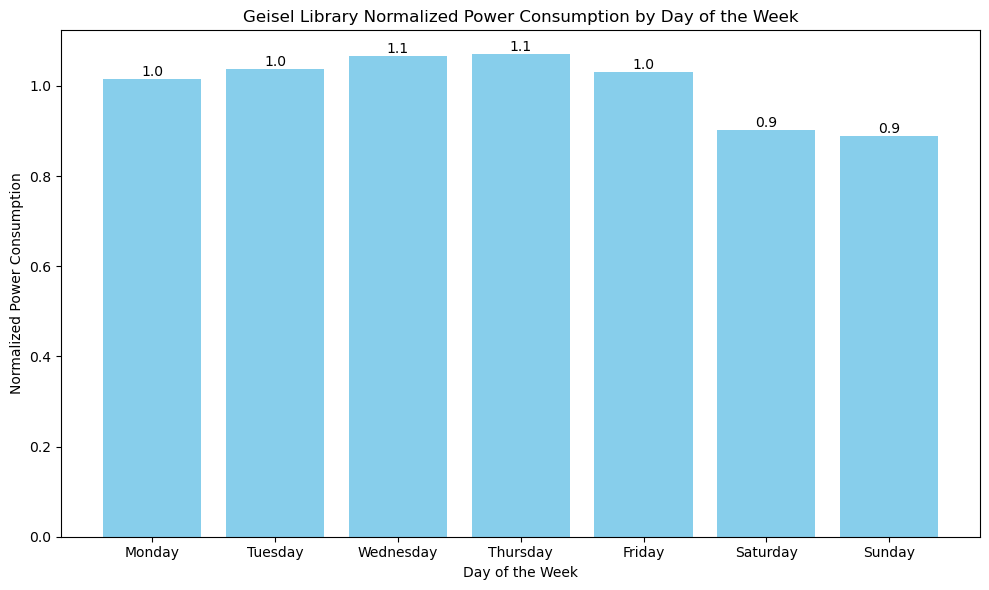

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the order of days to ensure the bars appear in the correct order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot the chart
plt.figure(figsize=(10, 6))
bars = plt.bar(day_order, geisel_weekly.loc[day_order, 'normalized_consumption'], color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Normalized Power Consumption')
plt.title(f'Geisel Library Normalized Power Consumption by Day of the Week')

# Adding the actual number values above each bar on the chart for better visual presentation
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [20]:
# Create a column for the day of the week
mcgill_df = mcgill_df.copy()
mcgill_df['day_of_week'] = mcgill_df['time'].dt.day_name()

# Aggregate power consumption by day of the week
mcgill_weekly = mcgill_df.groupby(['day_of_week']).agg({'power_consumption (mW)': 'mean'}).reset_index()

# Convert the power consumption values from mW to KW/h and rename the column appropriately
mcgill_weekly['power_consumption (mW)'] = mcgill_weekly['power_consumption (mW)'] * 60 / 1_000_000
mcgill_weekly.rename(columns = {'power_consumption (mW)': 'power_consumption (KW/h)'}, inplace=True)

# Create a column for the normalized consumption, or the consumption compared to the average across the entire campus
mcgill_avg_consumption = weekly_avg.loc[weekly_avg['building_name'] == 'McGill Hall', 'weekly_avg_consumption'].values[0] * 60 / 1_000_000
mcgill_weekly['normalized_consumption'] = mcgill_weekly['power_consumption (KW/h)'] / mcgill_avg_consumption

# Set the day of the week to the index
mcgill_weekly.set_index('day_of_week', inplace=True)

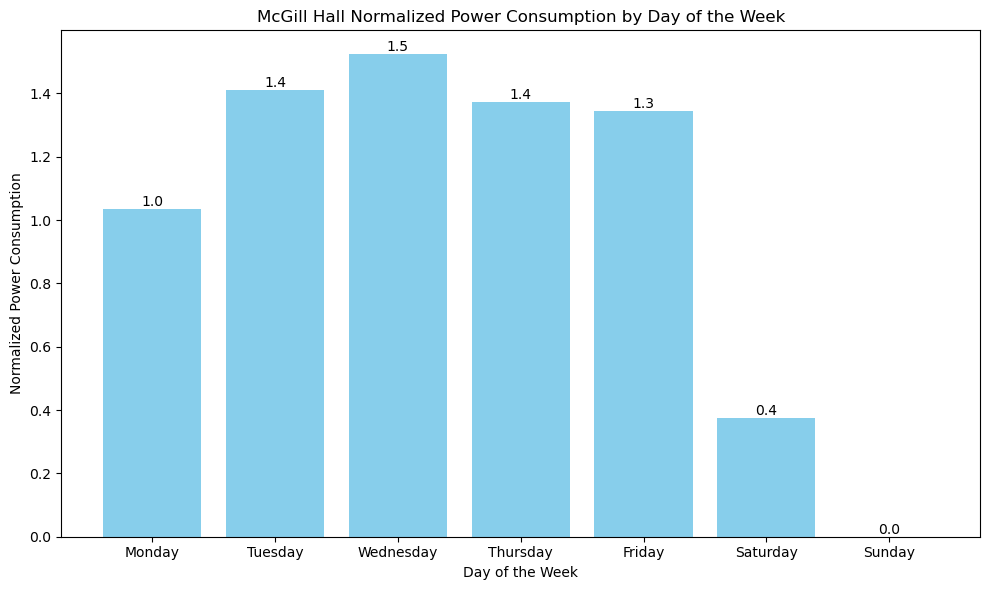

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the order of days to ensure the bars appear in the correct order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot the chart
plt.figure(figsize=(10, 6))
bars = plt.bar(day_order, mcgill_weekly.loc[day_order, 'normalized_consumption'], color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Normalized Power Consumption')
plt.title(f'McGill Hall Normalized Power Consumption by Day of the Week')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [24]:
# Create a column for the day of the week
IRPS_df = IRPS_df.copy()
IRPS_df['day_of_week'] = IRPS_df['time'].dt.day_name()

# Aggregate power consumption by day of the week
IRPS_weekly = IRPS_df.groupby(['day_of_week']).agg({'power_consumption (mW)': 'mean'}).reset_index()

# Convert the power consumption values from mW to KW/h and rename the column appropriately
IRPS_weekly['power_consumption (mW)'] = IRPS_weekly['power_consumption (mW)'] * 60 / 1_000_000
IRPS_weekly.rename(columns = {'power_consumption (mW)': 'power_consumption (KW/h)'}, inplace=True)

# Create a column for the normalized consumption, or the consumption compared to the average across the entire campus
IRPS_avg_consumption = weekly_avg.loc[weekly_avg['building_name'] == 'IRPS Robinson Hall', 'weekly_avg_consumption'].values[0] * 60 / 1_000_000
IRPS_weekly['normalized_consumption'] = IRPS_weekly['power_consumption (KW/h)'] / IRPS_avg_consumption

# Set the day of the week to the index
IRPS_weekly.set_index('day_of_week', inplace=True)

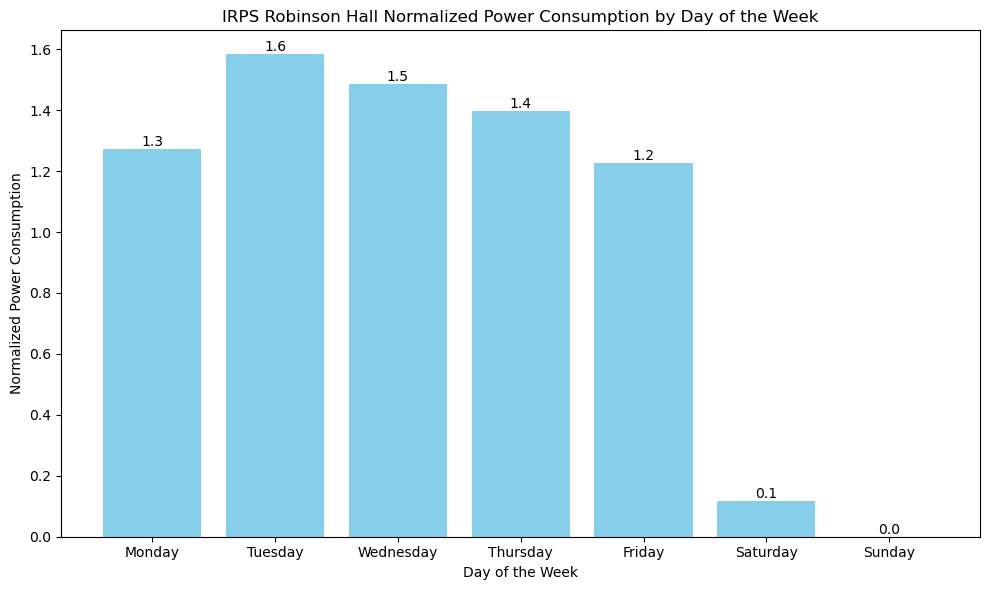

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the order of days to ensure the bars appear in the correct order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot the chart
plt.figure(figsize=(10, 6))
bars = plt.bar(day_order, IRPS_weekly.loc[day_order, 'normalized_consumption'], color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Normalized Power Consumption')
plt.title(f'IRPS Robinson Hall Normalized Power Consumption by Day of the Week')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [26]:
# Create a column for the day of the week
center_df = center_df.copy()
center_df['day_of_week'] = center_df['time'].dt.day_name()

# Aggregate power consumption by day of the week
center_weekly = center_df.groupby(['day_of_week']).agg({'power_consumption (mW)': 'mean'}).reset_index()

# Convert the power consumption values from mW to KW/h and rename the column appropriately
center_weekly['power_consumption (mW)'] = center_weekly['power_consumption (mW)'] * 60 / 1_000_000
center_weekly.rename(columns = {'power_consumption (mW)': 'power_consumption (KW/h)'}, inplace=True)

# Create a column for the normalized consumption, or the consumption compared to the average across the entire campus
center_avg_consumption = weekly_avg.loc[weekly_avg['building_name'] == 'Center Hall', 'weekly_avg_consumption'].values[0] * 60 / 1_000_000
center_weekly['normalized_consumption'] = center_weekly['power_consumption (KW/h)'] / center_avg_consumption

# Set the day of the week to the index
center_weekly.set_index('day_of_week', inplace=True)

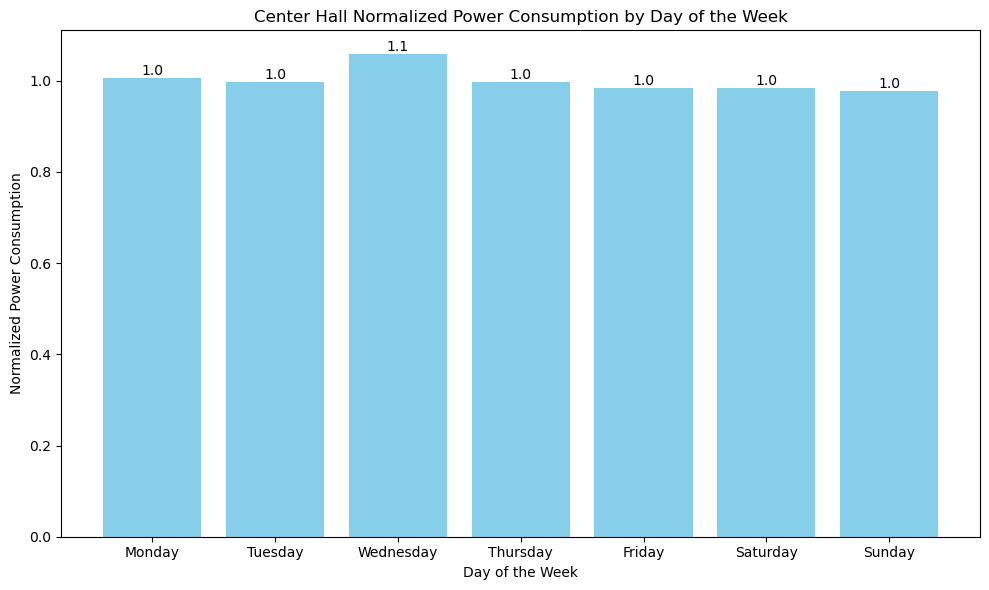

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the order of days to ensure the bars appear in the correct order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot the chart
plt.figure(figsize=(10, 6))
bars = plt.bar(day_order, center_weekly.loc[day_order, 'normalized_consumption'], color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Normalized Power Consumption')
plt.title(f'Center Hall Normalized Power Consumption by Day of the Week')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
from PIL import Image

number_of_frames = 7

# Assuming you have saved each frame as an image
frames = [Image.open(fr'C:\Users\vaugh\Desktop\smart-plug-research\frame_{i}.png') for i in range(number_of_frames)]

# Save as GIF
frames[0].save(r'C:\Users\vaugh\Desktop\smart-plug-research\heatmap_animation.gif', save_all=True, append_images=frames[1:], optimize=False, duration=1000, loop=0)